In [21]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import skimage
from skimage.filters import threshold_otsu

ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [22]:
class ShapesConfig(Config):
    # Give the configuration a recognizable name
    NAME = "fibroblast"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    NUM_CLASSES = 1 + 2  # background + 2 young and old
    IMAGE_MIN_DIM = 10
    IMAGE_MAX_DIM = 101
    RPN_ANCHOR_SCALES = (2, 4, 8, 16, 32)  # anchor side in pixels
    TRAIN_ROIS_PER_IMAGE = 8
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5
config = ShapesConfig()
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class ShapesDataset(utils.Dataset):
    def list_images(self,data_dir):
        self.add_class("fibroblast",1,CLASS_NAMES[0])
        self.add_class("fibroblast",2,CLASS_NAMES[1])
        train_images = list(data_dir.glob('*\*\image\*.jpg'))
        for idx,train_image in enumerate(train_images):
            ground = os.path.normpath(train_image).split(os.path.sep)[-4]
            self.add_image("fibroblast",image_id=idx,path=train_image,truth=ground,
                           height=config.IMAGE_SHAPE[0],width=config.IMAGE_SHAPE[1])

    def list_masks(self,data_dir):
        self.add_class("fibroblast",1,CLASS_NAMES[0])
        self.add_class("fibroblast",2,CLASS_NAMES[1])
        label_images = list(data_dir.glob('*\*\label\*.jpg'))
        for idx,label_image in enumerate(label_images):
            ground = os.path.normpath(label_image).split(os.path.sep)[-4]
            self.add_image("fibroblastlabel",image_id=idx,path=label_image,truth=ground,
                           height=config.IMAGE_SHAPE[0],width=config.IMAGE_SHAPE[1])

    def load_mask(self, image_id):
        # Load binary mask
        info = self.image_info[image_id]
        mask = np.zeros([info['height'], info['width'], len(self.class_names)], dtype=np.uint8)
        label = info['truth']
        # 0 is background
        labelidx = np.argwhere(CLASS_NAMES == label).flat[0]+1
        print(label)
        print(labelidx)
        masklayer = skimage.io.imread(info['path'])
        thresh = threshold_otsu(masklayer)
        binary = masklayer > thresh
        # plt.imshow(binary)
        mask[:, :, 0] = binary
        plt.imshow(mask)
        class_ids = np.array([labelidx])
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [23]:
dataset_train = ShapesDataset()
data_dir = pathlib.Path(r'C:\Users\kuki\Desktop\Research\Skin\RCNN data\RCNNtrain')
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_store"])
print(CLASS_NAMES)
dataset_train.list_images(data_dir)
dataset_train.prepare()
dataset_trainlabel = ShapesDataset()
dataset_trainlabel.list_masks(data_dir)
dataset_trainlabel.prepare()

['old' 'young']


old
1
39
['BG', 'old', 'young']


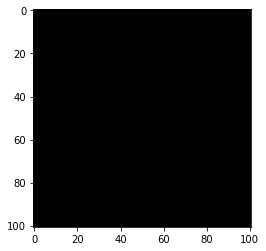

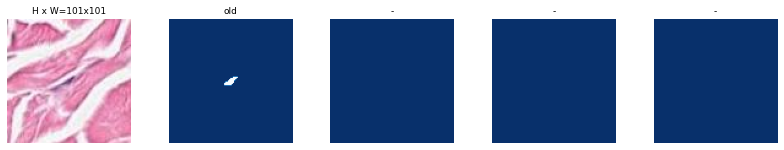

In [24]:
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_trainlabel.load_mask(image_id)
    print(np.sum(mask))
    print(dataset_train.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
